In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from matplotlib import cm

import wecopttool as wot
from capytaine.io.meshio import load_from_meshio
import os

wot.set_loglevel('ERROR', capytaine=False)


In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [3]:
wavefreq = 0.4# Hz
f1 = wavefreq
nfreq = 5

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
amplitude = 0.15 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

In [4]:
bem_data = wot.run_bem(fb, freq)


The resolution of the mesh might be insufficient for omega ranging from 10.053 to 12.566.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


[16:00:28] WARNING  Mesh resolution for 4 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 10.053 to 12.566.      
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

Output()

In [5]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

In [6]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
# controller = None
# nstate_opt = 2*nfreq

controller = wot.pto.controller_pi
nstate_opt = 2

# controller = wot.pto.controller_p
# nstate_opt = 1

loss = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
f_add = {'PTO': pto.force_on_wec}


In [7]:
# Constraint -- needed for convergence with PI and mech power
f_max = 5000.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())
ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]
# constraints = []

In [24]:
add_friction = 1000

wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=add_friction,
    f_add=f_add,
)

In [25]:
obj_fun_elec = pto.average_power
obj_fun_mech = pto.mechanical_average_power

options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results_elec = wec.solve(
    waves, 
    obj_fun_elec, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )
opt_average_power = results_elec[0].fun
print(f'Optimal average power: {opt_average_power} W')


results_mech = wec.solve(
    waves, 
    obj_fun_mech, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=1e-4,
    scale_obj=scale_obj,
    )
opt_average_mech_power = results_mech[0].fun
print(f'Optimal mechanical power: {opt_average_mech_power} W')

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.277071616653714
            Iterations: 33
            Function evaluations: 44
            Gradient evaluations: 33
Optimal average power: -127.70716166537139 W


C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.9998721052027455
            Iterations: 21
            Function evaluations: 29
            Gradient evaluations: 21
Optimal mechanical power: -199.98721052027454 W


## Sankey diagrams

### Existing


In [26]:
hd_fric = wot.add_linear_friction(bem_data, friction = add_friction) 


(<Figure size 800x400 with 1 Axes>, <Axes: >)

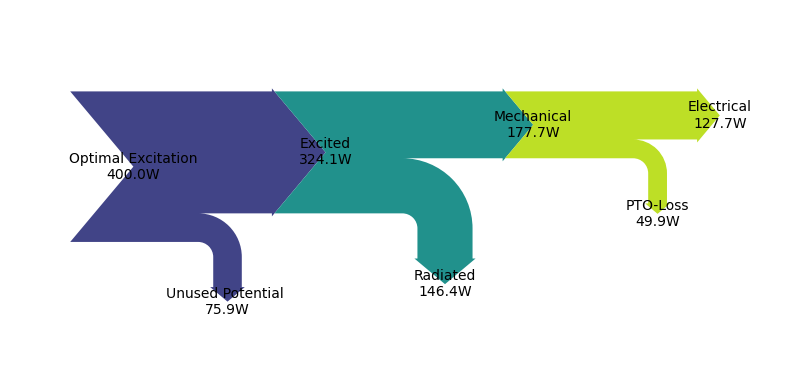

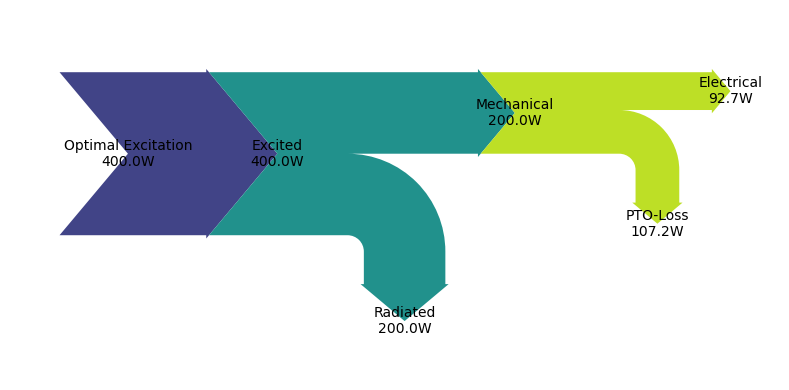

In [27]:
intrinsic_impedance = wot.hydrodynamic_impedance(hd_fric)

p_flows_elec = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results_elec, 
                                              waves, 
                                              intrinsic_impedance)
p_flows_mech = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results_mech, 
                                              waves, 
                                              intrinsic_impedance)                                              
wot.utilities.plot_power_flow(p_flows_elec)
wot.utilities.plot_power_flow(p_flows_mech)

In [28]:
from matplotlib.sankey import Sankey
def calculate_power_flows_new(wec, 
                          pto, 
                          results, 
                          waves, 
                          intrinsic_impedance)-> dict[str, float]:
    """Calculate power flows into a :py:class:`wecopttool.WEC`
        and through a :py:class:`wecopttool.pto.PTO` based on the results
        of :py:meth:`wecopttool.WEC.solve` for a single wave realization.

    Parameters
    ----------
    wec
        WEC object of :py:class:`wecopttool.WEC` 
    pto
        PTO object of :py:class:`wecopttool.pto.PTO`
    results
        Results produced by :py:func:`scipy.optimize.minimize` for a single wave
        realization.
    waves
        :py:class:`xarray.Dataset` with the structure and elements
        shown by :py:mod:`wecopttool.waves`.
    intrinsic_impedance: DataArray
        Complex intrinsic impedance matrix produced by 
        :py:func:`wecopttool.hydrodynamic_impedance`.
        Dimensions: omega, radiating_dofs, influenced_dofs
    """
    wec_fdom, _ = wec.post_process(wec, results, waves)
    x_wec, x_opt = wec.decompose_state(results[0].x)

    #power quntities from solver
    P_mech = pto.mechanical_average_power(wec, x_wec, x_opt, waves)
    P_out = pto.average_power(wec, x_wec, x_opt, waves)

    #compute analytical power flows
    Fexc_FD_full = wec_fdom[0].force.sel(type=
                        ['Froude_Krylov',
                         'diffraction']).sum('type')
    Rad_res = np.real(intrinsic_impedance.squeeze())
    Vel_FD = wec_fdom[0].vel

    P_max_abs, P_exc, P_rad = [], [], []

    #This solution requires radiation resistance matrix Rad_res to be invertible
    # TODO In the future we might want to add an entirely unconstrained solve 
    # for optimized mechanical power

    for om in Rad_res.omega.values:   
        #use frequency vector from intrinsic impedance (no zero freq)
        #Eq. 6.69
        #Dofs are row vector, which is transposed in standard convention
        Fexc_FD_t = np.atleast_2d(Fexc_FD_full.sel(omega = om))    
        Fexc_FD = np.transpose(Fexc_FD_t)
        R_inv = np.linalg.inv(np.atleast_2d(Rad_res.sel(omega= om)))
        P_max_abs.append((1/8)*(Fexc_FD_t@R_inv)@np.conj(Fexc_FD)) 
        #Eq.6.57
        U_FD_t = np.atleast_2d(Vel_FD.sel(omega = om))
        U_FD = np.transpose(U_FD_t)
        R = np.atleast_2d(Rad_res.sel(omega= om))
        P_rad.append((1/2)*(U_FD_t@R)@np.conj(U_FD))
        #Eq. 6.56 (replaced pinv(Fe)*U with U'*conj(Fe) 
        # as suggested in subsequent paragraph)
        P_exc.append((1/4)*(Fexc_FD_t@np.conj(U_FD) + U_FD_t@np.conj(Fexc_FD)))

    power_flows = {
        'Optimal Excitation' : 2* np.sum(np.real(P_max_abs)),#eq 6.68 
        'Max Absorbed': 1* np.sum(np.real(P_max_abs)),
        'Radiated': 1*np.sum(np.real(P_rad)), 
        'Excitation': 1*np.sum(np.real(P_exc)), 
        'Out': -1*P_out, 
        'Mechanical': -1*P_mech, 
                  }

    power_flows['Absorbed'] =  (
        power_flows['Excitation'] 
        - power_flows['Radiated']
            )
    power_flows['Deficit Excitation'] =  (
        power_flows['Optimal Excitation'] 
        - power_flows['Excitation']
            )
    power_flows['Deficit Absorbed'] =  (
        power_flows['Max Absorbed'] 
        - power_flows['Absorbed']
            ) 
    power_flows['Deficit Radiated'] =  (
        power_flows['Deficit Excitation'] 
        - power_flows['Deficit Absorbed']
            )     
    power_flows['PTO Loss'] = (
        power_flows['Mechanical'] 
        -  power_flows['Out']
            )
    return power_flows
    


In [29]:
def plot_power_flow_new(power_flows: dict[str, float], 
                        plot_reference = True,
                        sup_title = '', 
                        fig = None, 
                        axes = None):
    """Plot power flow through a WEC as Sankey diagram.

    Parameters
    ----------
    power_flows
        Power flow dictionary produced by for example by
        :py:func:`wecopttool.utilities.calculate_power_flows`.
        Required keys: 'Optimal Excitation', 'Radiated', 'Actual Excitation'
        'Electrical (solver)', 'Mechanical (solver)',
        'Absorbed', 'Unused Potential', 'PTO Loss'
    """
    # fig = plt.figure(figsize = [8,4])
    # ax = fig.add_subplot(1, 1, 1,)

#     clrs = self.colors
    #TODO: create a colors attribute in utils
    clrs = {'hydro':        (0.267004, 0.004874, 0.329415, 1.0), #viridis(0.0)
                'hydro_mech':   (0.229739, 0.322361, 0.545706, 1.0), #viridis(0.25)
                'mech':         (0.127568, 0.566949, 0.550556, 1.0), #viridis(0.5)
                'mech_elec':    (0.369214, 0.788888, 0.382914, 1.0), #viridis(0.75)
                'elec':         (0.974417, 0.90359, 0.130215, 0.5), #viridis(0.99)
                }
    # fig = None
    
    if axes is None and fig is None:
        fig, axes = plt.subplots(nrows = 1, ncols= 1,
                tight_layout=True, 
                # sharex= True,
                figsize= [8, 4])
    #TODO write elif statements that prevent using either argument as None
                
    len_trunk = 1.0
    # plt.viridis()
    if plot_reference:
        sankey = Sankey(ax=axes, 
                        scale= 1/power_flows['Optimal Excitation'],
                        offset= 0,
                        format = '%.1f',
                        shoulder = 0.02,
                        tolerance=1e-03*power_flows['Optimal Excitation'],
                        unit = 'W')
        sankey.add(flows=[power_flows['Optimal Excitation'],
                    -1*power_flows['Deficit Excitation'],
                    -1*power_flows['Excitation']], 
            labels = [' Optimal \n Excication ', 
                    'Deficit \n Excitation', 
                    'Excitation'], 
            orientations=[0, 0,  0],#arrow directions,
            pathlengths = [0.15,0.15,0.15],
            trunklength = len_trunk,
            edgecolor = 'None',
            facecolor = clrs['hydro'],
                alpha = 0.1,
            label = 'Reference',
                )
        n_diagrams = 1
        init_diag  = 0
        if power_flows['Deficit Excitation'] > 0.1:
            sankey.add(flows=[power_flows['Deficit Excitation'],
                        -1*power_flows['Deficit Radiated'],
                        -1*power_flows['Deficit Absorbed'],], 
                labels = ['XX Deficit Exc', 
                        'Deficit \n Radiated',
                            'Deficit \n Absorbed', ], 
                prior= (0),
                connect=(1,0),
                orientations=[0, 1,  0],#arrow directions,
                pathlengths = [0.15,0.01,0.15],
                trunklength = len_trunk,
                edgecolor = 'None',
                facecolor = clrs['hydro_mech'],
                alpha = 0.3, #viridis(0.2)
                label = 'Reference',
                    )
            n_diagrams = n_diagrams +1
    else:
        sankey = Sankey(ax=axes, 
                        scale= 1/power_flows['Excitation'],
                        offset= 0,
                        format = '%.1f',
                        shoulder = 0.02,
                        tolerance=1e-03*power_flows['Excitation'],
                        unit = 'W')
        n_diagrams = 0
        init_diag = None

    sankey.add(flows=[power_flows['Excitation'],
                        -1*(power_flows['Absorbed'] + power_flows['Radiated']),
                        ], 
                labels = ['Excitation', 
                        'Excitaion'], 
                prior = init_diag,
                connect=(2,0),
                orientations=[0,  -0],#arrow directions,
                pathlengths = [.15,0.15],
                trunklength = len_trunk,
                edgecolor = 'None',
                facecolor = clrs['hydro'] #viridis(0.9)
        )

    sankey.add(flows=[
                (power_flows['Absorbed'] + power_flows['Radiated']),
                -1*power_flows['Radiated'],
                -1*power_flows['Absorbed'],
                ], 
                labels = ['Excitation', 
                        'Radiated', 
                        'Absorbed'], 
                # prior= (0),
                prior= (n_diagrams),
                connect=(1,0),
                orientations=[0, -1,  -0],#arrow directions,
                pathlengths = [0.15,0.2,0.15],
                trunklength = len_trunk-0.2,
                edgecolor = 'None', 
                facecolor = clrs['hydro_mech'] #viridis(0.5)
        )
        #single arrow
    sankey.add(flows=[power_flows['Absorbed'],
                        -1*power_flows['Mechanical'],
                        ], 
                labels = ['Absorbed', 
                        'Mechanical'], 
                prior= (n_diagrams+1),
                connect=(2,0),
                orientations=[0,  -0],#arrow directions,
                pathlengths = [.15,0.15],
                trunklength = len_trunk,
                edgecolor = 'None',
                facecolor = clrs['mech'] #viridis(0.9)
        )
    sankey.add(flows=[(power_flows['Mechanical']),
                        -1*power_flows['PTO Loss'],
                        -1*power_flows['Out'],
                        ], 
                labels = ['Mechanical', 
                        'PTO-Loss' , 
                        'Out'], 
                prior= (n_diagrams+2),
                connect=(1,0),
                orientations=[0, -1,  -0],#arrow directions,
                pathlengths = [.15,0.2,0.15],
                trunklength = len_trunk,
                edgecolor = 'None',
                facecolor = clrs['mech_elec'] #viridis(0.9)
        )
    sankey.add(flows=[(power_flows['Out']),
                        -1*power_flows['Out'],
                        ], 
                labels = ['', 
                        'Out'], 
                prior= (n_diagrams+3),
                connect=(2,0),
                orientations=[0,  -0],#arrow directions,
                pathlengths = [.15,0.15],
                trunklength = len_trunk,
                edgecolor = 'None',
                facecolor = clrs['elec'] #viridis(0.9)
        )


    diagrams = sankey.finish()

    for diagram in diagrams:
        for text in diagram.texts:
            text.set_fontsize(8)

    #Remvove labels that are double
    len_diagrams = len(diagrams)

    diagrams[len_diagrams-4].texts[0].set_text('') #remove exciation from hydro
    diagrams[len_diagrams-5].texts[-1].set_text('') #remove excitation from excitation
    diagrams[len_diagrams-3].texts[0].set_text('') #remove absorbed from absorbed
    diagrams[len_diagrams-2].texts[0].set_text('') #remove mech from mech-elec
    diagrams[len_diagrams-2].texts[-1].set_text('') #remove out from mech-elec
    diagrams[len_diagrams-1].texts[0].set_text('')  #remove out in from elec

    if len_diagrams > 5:
        axes.legend()
    if len_diagrams >6:
      diagrams[1].texts[0].set_text('')  

    fig.suptitle(sup_title)

    axes.axis("off")
    # plt.show()
    if fig is None:
        return fig, axes, 

In [30]:
p_flow_elec_new = calculate_power_flows_new(wec,
                                              pto, 
                                              results_elec, 
                                              waves, 
                                              intrinsic_impedance)
p_flow_mech_new = calculate_power_flows_new(wec,
                                              pto, 
                                              results_mech, 
                                              waves, 
                                              intrinsic_impedance)

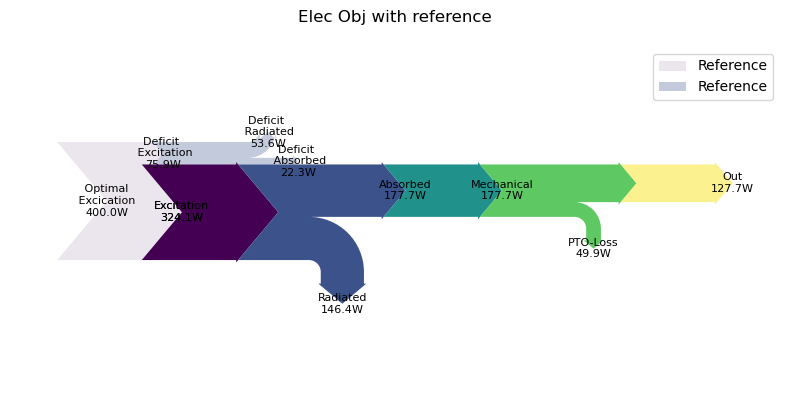

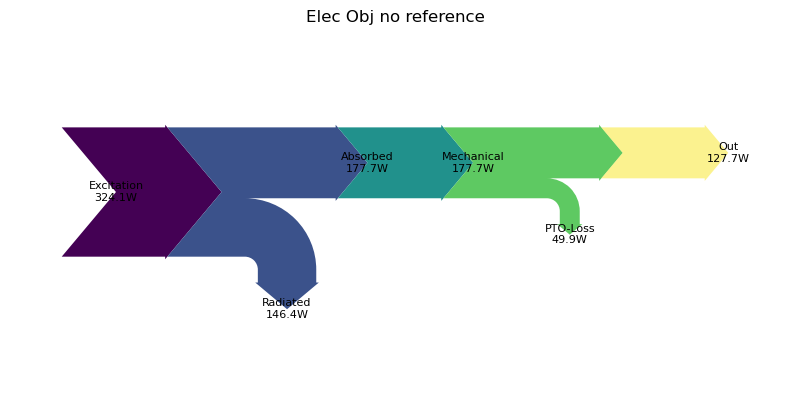

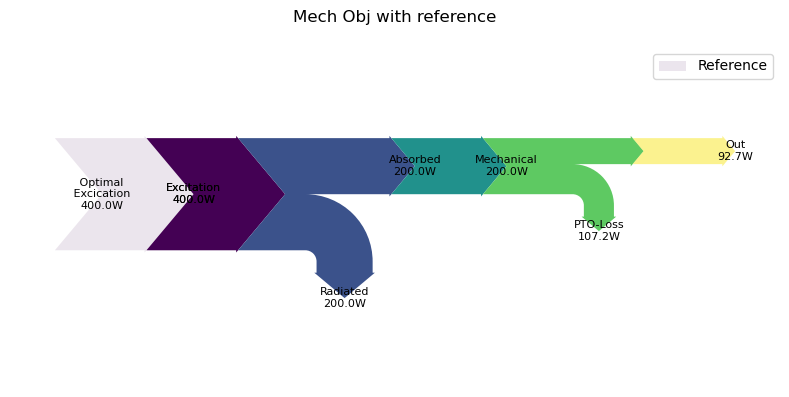

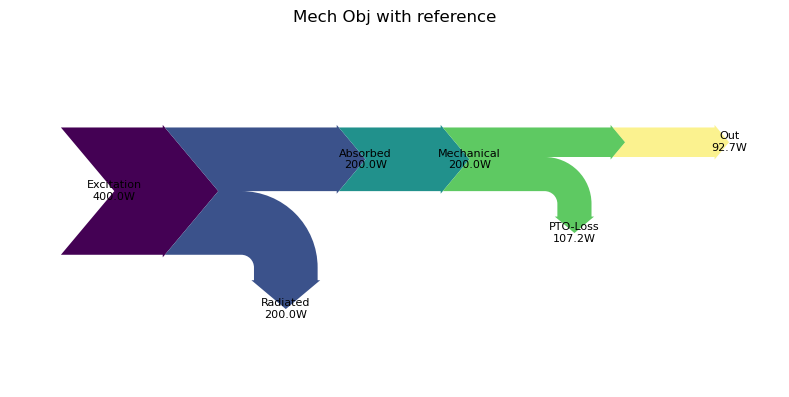

In [31]:
plot_power_flow_new(power_flows= p_flow_elec_new, sup_title='Elec Obj with reference')
plot_power_flow_new(power_flows= p_flow_elec_new, plot_reference=False , sup_title='Elec Obj no reference')

plot_power_flow_new(power_flows= p_flow_mech_new, sup_title='Mech Obj with reference')
plot_power_flow_new(power_flows= p_flow_mech_new, plot_reference=False, sup_title='Mech Obj with reference')


### 

##